### 1. 데이터 불러오기 및 확인

In [1]:
import pandas as pd

# 데이터 불러오기
mall = pd.read_csv('Mall_Customers.csv')

# 데이터 미리보기
mall.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [2]:
# 데이터 정보확인
mall.info()
print('\n--------결측치 확인--------')
print(mall.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

--------결측치 확인--------
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


### 2. 데이터 전처리

#### 데이터 분석에 사용하지 않는 컬럼 제거

In [3]:
# 분석에 사용하지 않는 컬럼 제거
mall = mall.drop(columns=['CustomerID'])
mall

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
...,...,...,...,...
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18


#### 데이터 인코딩

In [4]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first', dtype='int')
gender_encoded = one_hot_encoder.fit_transform(mall[['Gender']])
gender_encoded_df = pd.DataFrame(gender_encoded, columns=one_hot_encoder.get_feature_names_out(['Gender']))
mall = pd.concat([mall.drop(columns=['Gender']), gender_encoded_df], axis=1)

mall

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,19,15,39,1
1,21,15,81,1
2,20,16,6,0
3,23,16,77,0
4,31,17,40,0
...,...,...,...,...
195,35,120,79,0
196,45,126,28,0
197,32,126,74,1
198,32,137,18,1


#### 이상치 확인 및 처리

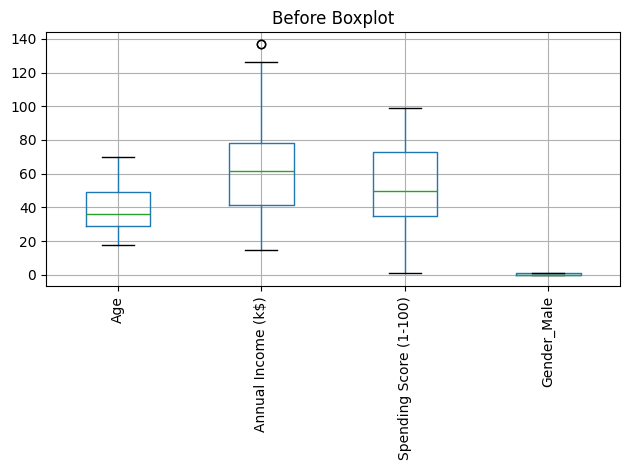

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# 이상치 처리 전 데이터 시각화
mall.boxplot()
plt.xticks(rotation=90)
plt.title('Before Boxplot')
plt.tight_layout()
plt.show()

In [6]:
import numpy as np

numerical_columns = mall.select_dtypes(include=[np.number]).columns
mall_processed = mall.copy()

for col in numerical_columns:
    Q1 = mall[col].quantile(0.25)
    Q3 = mall[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((mall[col] < lower_bound) | (mall[col] > upper_bound))
    if outliers.sum() > 0:
        # 이상치를 상한 및 하한값으로 대체
        mall_processed[col] = np.where(mall_processed[col] < lower_bound, lower_bound, mall_processed[col])
        mall_processed[col] = np.where(mall_processed[col] > upper_bound, upper_bound, mall_processed[col])

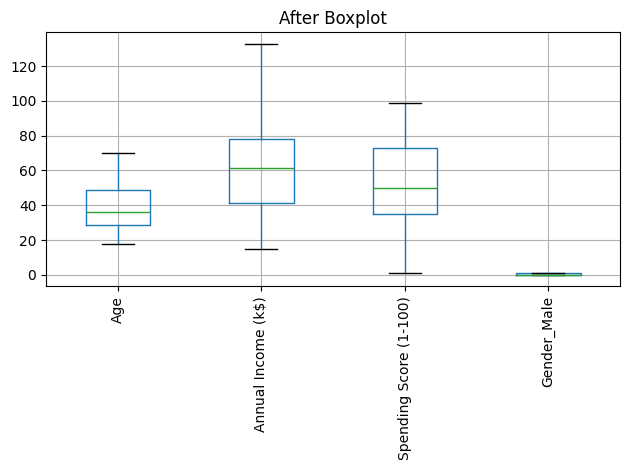

In [7]:
# 이상치 처리 후 데이터 시각화
mall_processed.boxplot()
plt.xticks(rotation=90)
plt.title('After Boxplot')
plt.tight_layout()
plt.show()

#### 스케일링

In [8]:
from sklearn.preprocessing import StandardScaler

# 숫자형 컬럼 선택 및 스케일링
scaler = StandardScaler()
data_scaled = scaler.fit_transform(mall_processed[numerical_columns])

### 3. 클러스터링 기법 적용

#### 계층적 군집화

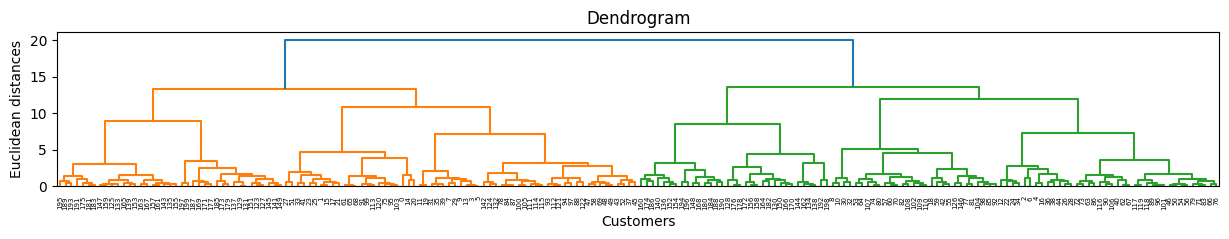

In [9]:
import scipy.cluster.hierarchy as sch

# 덴드로그램 생성
plt.figure(figsize=(15, 2))
dendrogram = sch.dendrogram(sch.linkage(data_scaled, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [10]:
from sklearn.cluster import AgglomerativeClustering

# 계층적 군집화 모델 생성
hc = AgglomerativeClustering(n_clusters=6, metric='euclidean', linkage='ward')

# 모델 학습 및 예측
mall_processed['Cluster'] = hc.fit_predict(mall_processed)

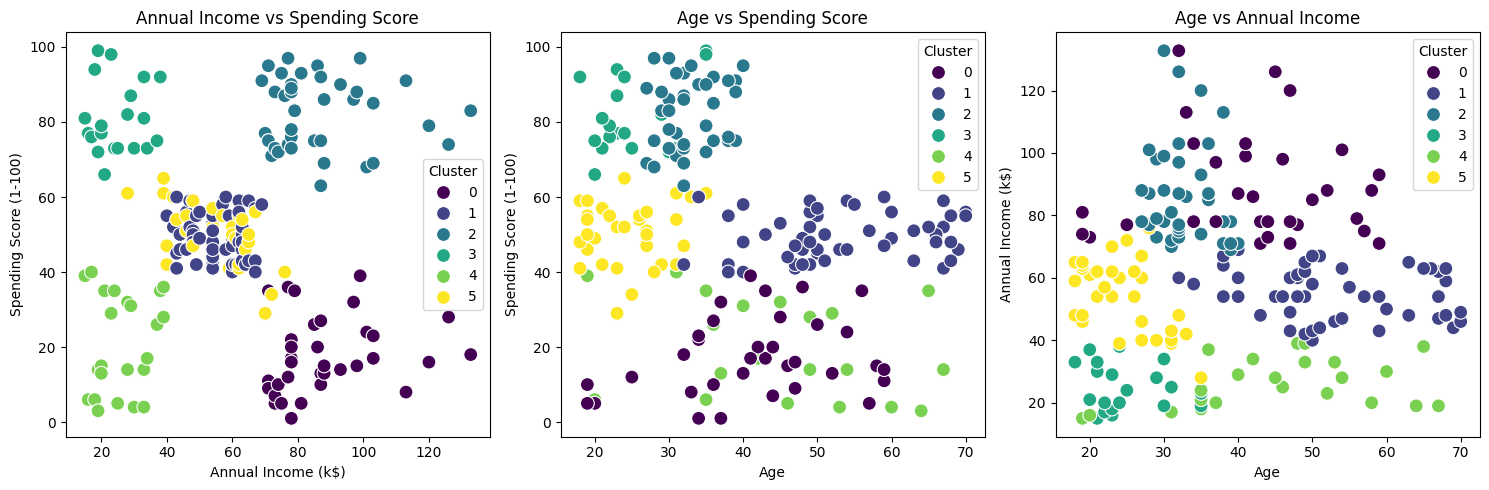

In [11]:
import seaborn as sns

# 2D 시각화 (여러 특성 조합)
plt.figure(figsize=(15, 5))

# 1. Annual Income vs Spending Score
plt.subplot(1, 3, 1)
sns.scatterplot(data=mall_processed, x='Annual Income (k$)', y='Spending Score (1-100)', 
                hue='Cluster', palette='viridis', s=100)
plt.title('Annual Income vs Spending Score')

# 2. Age vs Spending Score
plt.subplot(1, 3, 2)
sns.scatterplot(data=mall_processed, x='Age', y='Spending Score (1-100)', 
                hue='Cluster', palette='viridis', s=100)
plt.title('Age vs Spending Score')

# 3. Age vs Annual Income
plt.subplot(1, 3, 3)
sns.scatterplot(data=mall_processed, x='Age', y='Annual Income (k$)', 
                hue='Cluster', palette='viridis', s=100)
plt.title('Age vs Annual Income')

plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import silhouette_score

# 실루엣 계수 계산
hc_silhouette = silhouette_score(data_scaled, mall_processed['Cluster'])
print(f'실루엣 계수: {hc_silhouette}')

실루엣 계수: 0.25726966823205205


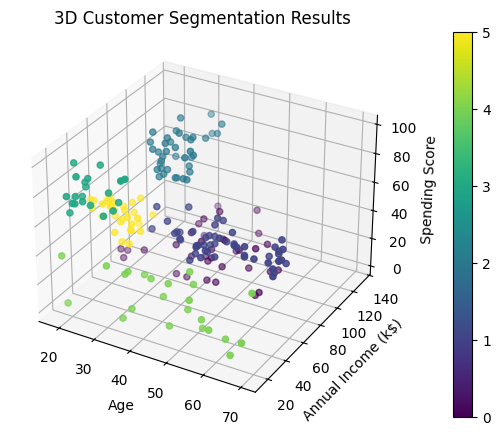

In [13]:
# 3D 시각화
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(mall_processed['Age'], 
                    mall_processed['Annual Income (k$)'], 
                    mall_processed['Spending Score (1-100)'],
                    c=mall_processed['Cluster'], 
                    cmap='viridis')
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score')
plt.title('3D Customer Segmentation Results')
plt.colorbar(scatter)
plt.show()

In [14]:
# 클러스터별 특성 분석
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
cluster_means = mall_processed.groupby('Cluster')[features].mean()
print("\n=== 클러스터별 평균값 ===")
print(cluster_means)


=== 클러스터별 평균값 ===
               Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                       
0        41.685714           88.107143               17.285714
1        53.215686           55.117647               49.470588
2        32.692308           86.429487               82.128205
3        24.850000           24.950000               81.000000
4        45.217391           26.304348               20.913043
5        24.531250           54.187500               50.250000


In [15]:

# 클러스터별 고객 수
cluster_sizes = mall_processed['Cluster'].value_counts().sort_index()
print("\n=== 클러스터별 고객 수 ===")
print(cluster_sizes)


=== 클러스터별 고객 수 ===
Cluster
0    35
1    51
2    39
3    20
4    23
5    32
Name: count, dtype: int64


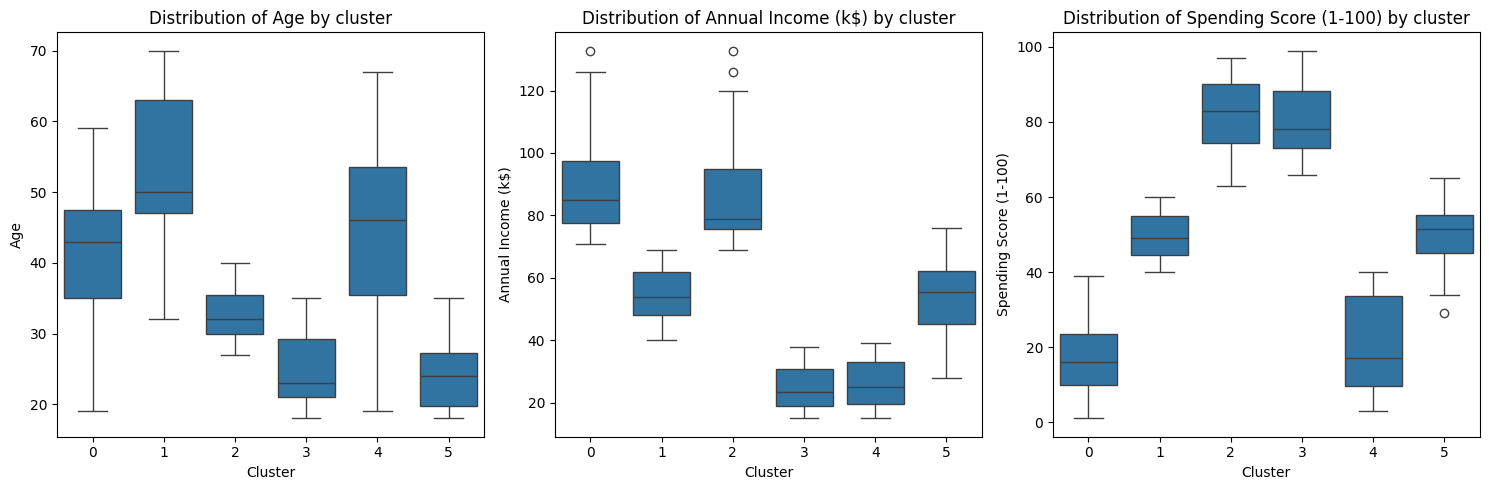

In [16]:
# 클러스터별 특성 분포 시각화
plt.figure(figsize=(15, 5))
for i, feature in enumerate(features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Cluster', y=feature, data=mall_processed)
    plt.title(f'Distribution of {feature} by cluster')
plt.tight_layout()
plt.show()

In [17]:

# 클러스터별 특성 요약
print("\n=== 클러스터 특성 요약 ===")
for cluster in sorted(mall_processed['Cluster'].unique()):
    cluster_data = mall[mall_processed['Cluster'] == cluster]
    print(f"\n클러스터 {cluster}:")
    print(f"고객 수: {len(cluster_data)}")
    print("평균값:")
    print(cluster_data[features].mean())
    print("-----"*10)


=== 클러스터 특성 요약 ===

클러스터 0:
고객 수: 35
평균값:
Age                       41.685714
Annual Income (k$)        88.228571
Spending Score (1-100)    17.285714
dtype: float64
--------------------------------------------------

클러스터 1:
고객 수: 51
평균값:
Age                       53.215686
Annual Income (k$)        55.117647
Spending Score (1-100)    49.470588
dtype: float64
--------------------------------------------------

클러스터 2:
고객 수: 39
평균값:
Age                       32.692308
Annual Income (k$)        86.538462
Spending Score (1-100)    82.128205
dtype: float64
--------------------------------------------------

클러스터 3:
고객 수: 20
평균값:
Age                       24.85
Annual Income (k$)        24.95
Spending Score (1-100)    81.00
dtype: float64
--------------------------------------------------

클러스터 4:
고객 수: 23
평균값:
Age                       45.217391
Annual Income (k$)        26.304348
Spending Score (1-100)    20.913043
dtype: float64
--------------------------------------------------

클러스터 5

### 4. 분류모델

In [18]:
# 해당 클러스터를 타겟으로 결정
mall_processed['Target'] = (mall_processed['Cluster'] == 5)
mall_processed

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male,Cluster,Target
0,19,15.00,39,1,4,False
1,21,15.00,81,1,3,False
2,20,16.00,6,0,4,False
3,23,16.00,77,0,3,False
4,31,17.00,40,0,4,False
...,...,...,...,...,...,...
195,35,120.00,79,0,2,False
196,45,126.00,28,0,0,False
197,32,126.00,74,1,2,False
198,32,132.75,18,1,0,False


#### 의사결정나무

In [19]:
from sklearn.model_selection import train_test_split

# 입력 변수와 타겟 변수
X = mall_processed.drop(columns=['Cluster', 'Target']) 
y = mall_processed['Target']

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 모델 생성 및 학습
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
ppv = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {ppv}")
print(f'Recall: {recall}')
print(f'F1 scorer : {f1}')

Accuracy: 0.925
Precision: 1.0
Recall: 0.7272727272727273
F1 scorer : 0.8421052631578947
